In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!ls archive

Location1.csv Location2.csv Location3.csv Location4.csv readme.txt


## Exploratory Data Analysis

In [3]:
file_dirs = [
    "archive/Location1.csv", 
    "archive/Location2.csv", 
    "archive/Location3.csv", 
    "archive/Location4.csv"
]

In [4]:
dfs = [
    pd.read_csv(path) for path in file_dirs
]

for df in dfs:
    df["Time"] = pd.to_datetime(df["Time"])
    df.index = df["Time"]

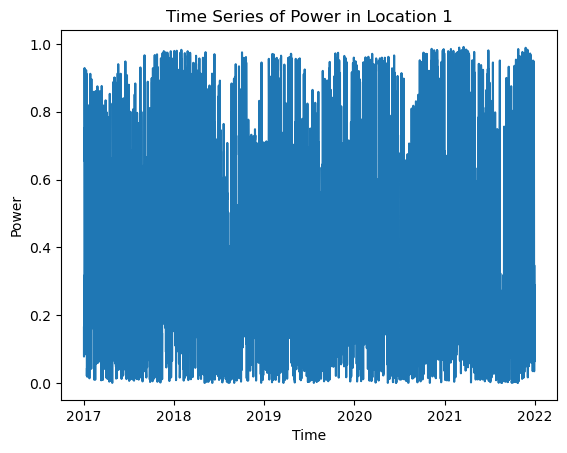

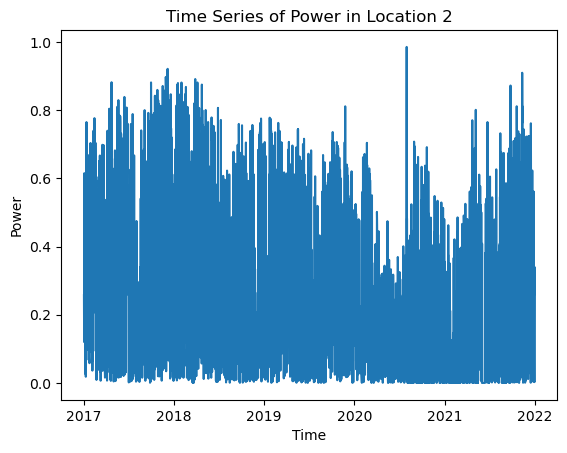

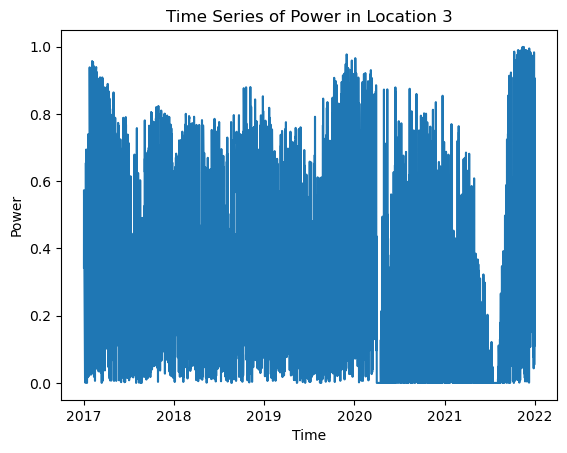

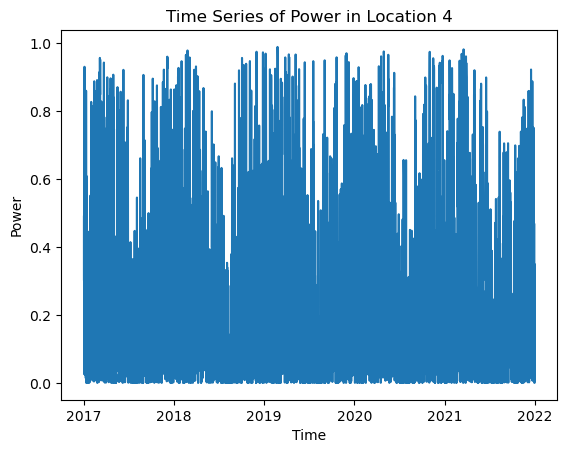

In [5]:
for i, df in enumerate(dfs):
    plt.plot(df["Time"], df["Power"])
    plt.title(f"Time Series of Power in Location {i + 1}")
    plt.xlabel("Time")
    plt.ylabel("Power")
    plt.show()

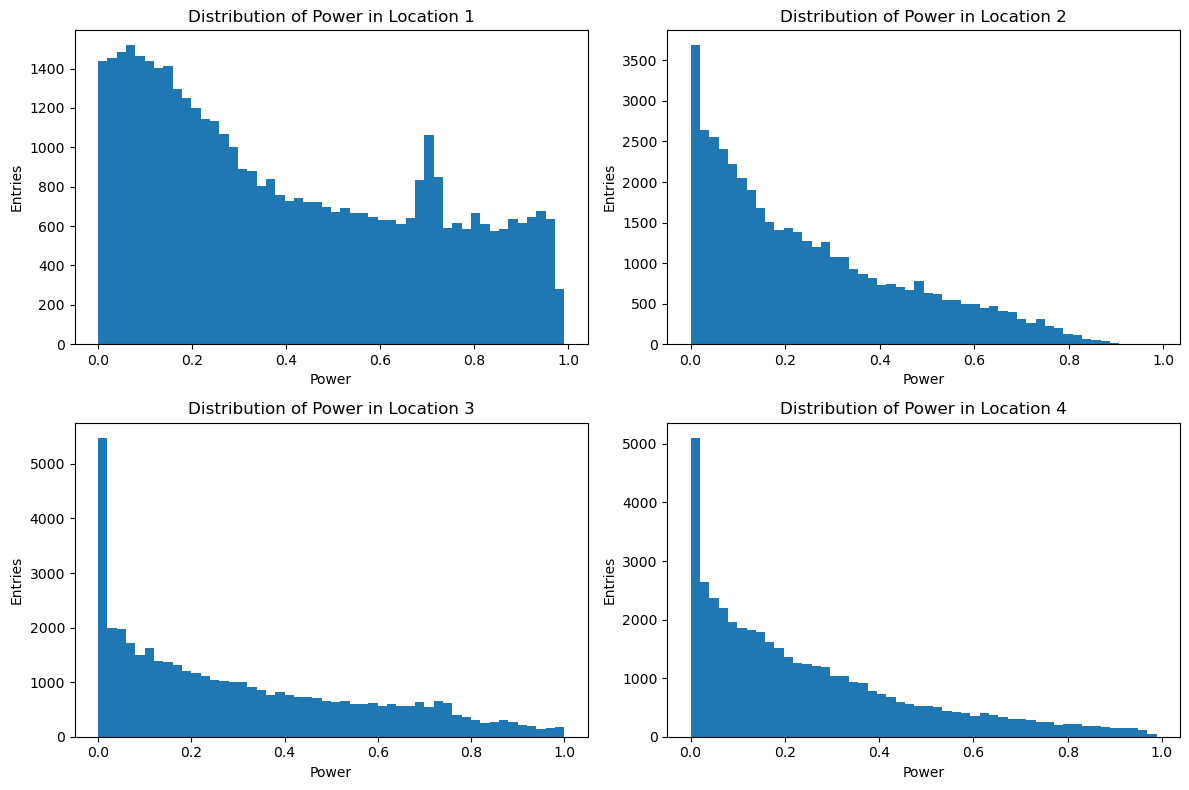

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns
axes = axes.flatten()  # Flatten to 1D array for easy iteration

for i, df in enumerate(dfs):
    axes[i].hist(df["Power"], bins=50)
    axes[i].set_title(f"Distribution of Power in Location {i + 1}")
    axes[i].set_xlabel("Power")
    axes[i].set_ylabel("Entries")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


The distribution of power looks skewed. Specifically, it looks positively skewed. This shows that the generation of wind power is rarely maximized.

In [21]:
for i, df in enumerate(dfs):
    df['month'] = pd.to_datetime(df['Time']).dt.month

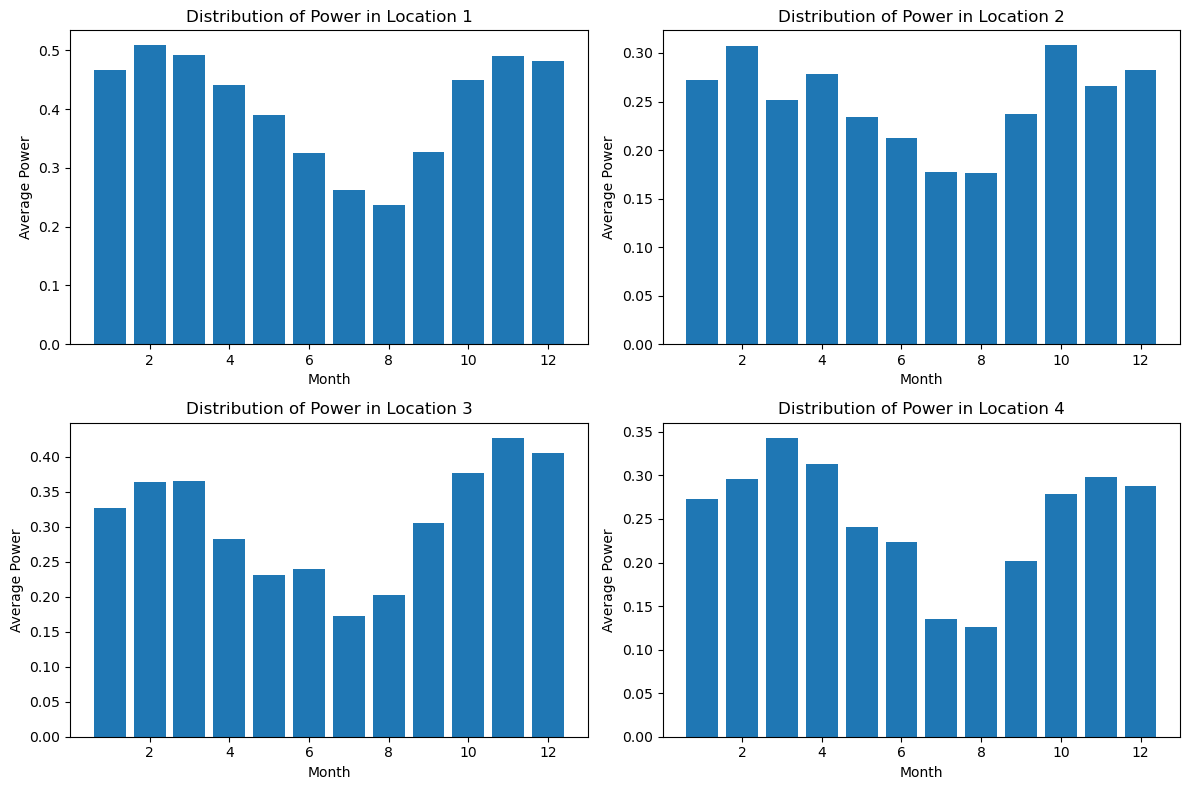

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns
axes = axes.flatten()  # Flatten to 1D array for easy iteration

for i, df in enumerate(dfs):
    axes[i].bar(
        df.groupby("month")["Power"].mean().index, 
        df.groupby("month")["Power"].mean()
    )
    axes[i].set_title(f"Distribution of Power in Location {i + 1}")
    axes[i].set_xlabel("Month")
    axes[i].set_ylabel("Average Power")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


Peak generation of power seems to come from February, March, October, and November.

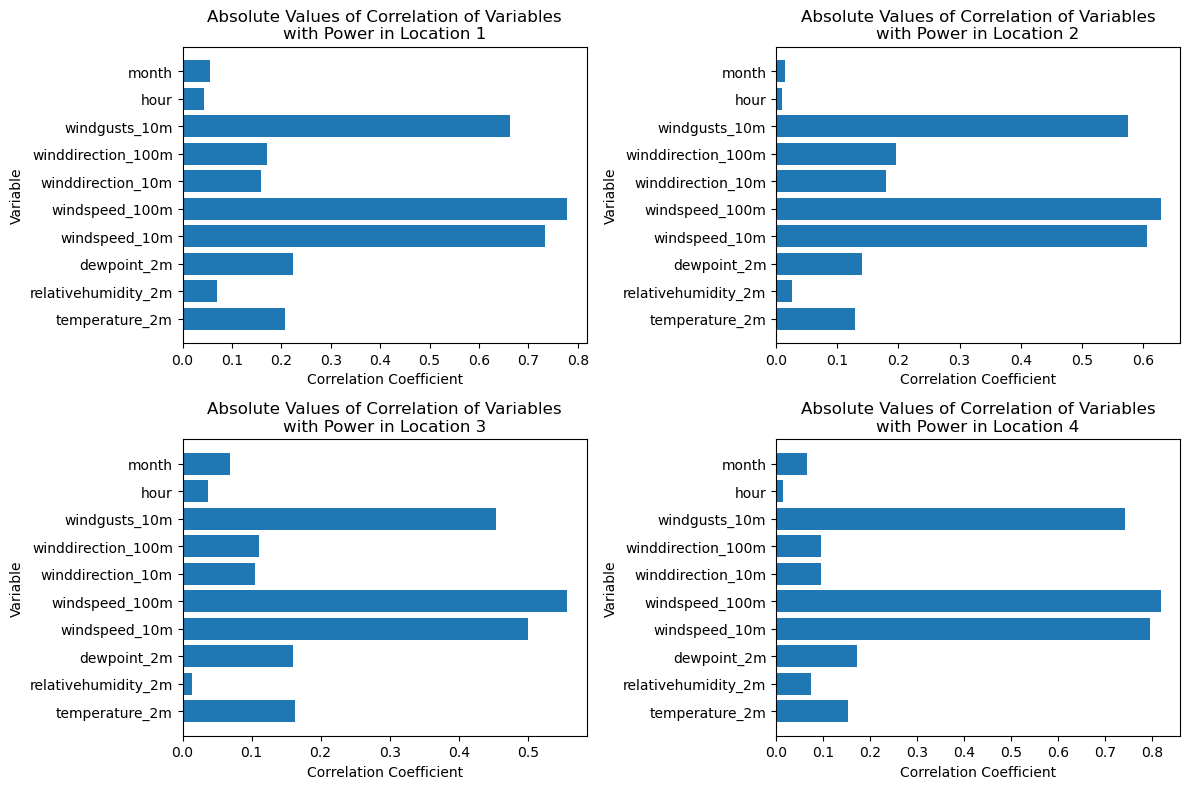

In [32]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, df in enumerate(dfs):
    corr_series = df.corr(numeric_only=True)["Power"].drop("Power")
    
    axes[i].barh(
        corr_series.index,
        np.abs(corr_series.values)
    )
    axes[i].set_title(
        "Absolute Values of Correlation of Variables\n"
        f"with Power in Location {i + 1}"
    )
    axes[i].set_xlabel("Correlation Coefficient")
    axes[i].set_ylabel("Variable")

plt.tight_layout()
plt.show()


`windgusts_10`, `windspeed_100m`, and `windspeed_10m` most likely have the most predictive power because they have the largest absolute values with power. However, this still has to be verified with SHAP values after the model has been created.